In [94]:
import sys
import numba
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append("../")

In [95]:
from lib_dolphin.audio import *

In [96]:
regions  = '../../datasets/l2.csv'
wav_file = '../../datasets/l2.wav'

n = 11
df = pd.read_csv(regions)
audio = raw(wav_file)
spectrograms = []
for _, row in df.iterrows():
    start, stop = row['starts'], row['stops']
    spec = spectrogram(audio[start:stop], lo=0, hi=512, win=1024, normalize=False)
    min_spec = spec.min()
    max_spec = spec.max()
    spec = (spec - min_spec) / (max_spec - min_spec)
    sum_spec = spec.sum(axis=1).reshape((len(spec), 1)).repeat(512, axis=1)
    spec = spec / sum_spec
    spectrograms.append(spec)
    if len(spectrograms) == n:
        break

In [109]:
from numba import jit

@jit
def interest_points(spec, th, r=3):
    T, F = spec.shape
    for t in range(r, T-r):
        for f in range(r, F-r):
            s = spec[t,f]
            sum_t = spec[t-r:t+r, f].sum() - s
            sum_f = spec[t, f-r:f+r].sum() - s 
            max_t = max(spec[t-r:t, f].max(), spec[t+1:t+r, f].max())
            max_f = max(spec[t, f-r:f].max(), spec[t, f+1:f+r].max())
            max_s = max(max_t, max_f) 
            noise = (1.0 / (2 * r)) * min(sum_t, sum_f) + th
            if s > max_s and s > noise:
                yield t, f

x = []
y = []
for t, f in interest_points(spectrograms[10], 2 * np.std(spectrograms[10])):
    x.append(t)
    y.append(f)

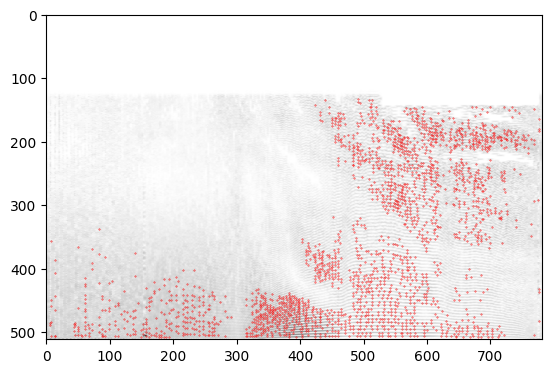

In [111]:
plt.imshow(1.0 - spectrograms[10].T, cmap='gray')
plt.scatter(x, y, s=0.1, color='red')

In [76]:
len(x)

7575